# 不知道叫啥

In [31]:
# 导入所有需要的包
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 1 数据导入

In [32]:
# 读取上海市2018年9月1日的共享单车数据
data = pd.read_csv(r'./assets/data/data0901.csv')
data

,BIKE_ID,DATA_TIME,LOCK_STATUS,LONGITUDE,LATITUDE
0,713ED7B044393233E0533C0BA8C09291,2018-09-01 0:00:49,0,121.531489,31.263296
1,713ED78FC0813233E0533C0BA8C09291,2018-09-01 0:00:49,0,121.363938,31.212551
2,7169493311DD0D74E0533E0BA8C01BB4,2018-09-01 0:00:12,1,121.488291,31.264857
3,713ED795F1033233E0533C0BA8C09291,2018-09-01 0:00:06,1,121.345189,31.135745
4,713ED7AF8E213233E0533C0BA8C09291,2018-09-01 0:00:49,0,121.364748,31.258107
...,...,...,...,...,...
3063365,713ED79FD6C23233E0533C0BA8C09291,2018-09-01 10:25:50,1,121.449317,31.246356
3063366,713ED79F3BAF3233E0533C0BA8C09291,2018-09-01 14:46:43,1,121.429002,31.183046
3063367,713ED7969D603233E0533C0BA8C09291,2018-09-01 2:49:39,1,121.223636,31.231712
3063368,713ED7A760F03233E0533C0BA8C09291,2018-09-01 18:24:33,1,121.673009,31.301073


此时，数据中的 `DATA_TIME` 字段中的时间为字符串格式，直接将其格式转换为 `pandas` 内置的时间格式以便后续排序，并粗略筛选研究范围内的数据。

In [33]:
# 转换数据的时间
data['DATA_TIME'] = pd.to_datetime(data['DATA_TIME'])
# 筛选研究范围内的数据
data = data[(data['LONGITUDE']<122)&
            (data['LONGITUDE']>120)&
            (data['LATITUDE']<32)&
            (data['LATITUDE']>30)]

取出其中一辆单车的数据，并按时间顺序对数据排序，以便观察数据的采集情况。可以看到，单独取出一辆单车的数据并以时间排序，数据的锁状态为 `0` 和 `1` 交替出现。

In [34]:
tmp = data[data['BIKE_ID']=='713ED79C59CC3233E0533C0BA8C09291']
tmp.sort_values(by = ['DATA_TIME'])

,BIKE_ID,DATA_TIME,LOCK_STATUS,LONGITUDE,LATITUDE
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:06:54,0,121.550754,31.247030
1823717,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:15:11,1,121.538810,31.240057
2278567,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:45:28,0,121.538906,31.239970
2249403,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:55:58,1,121.550667,31.247302
2370822,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:50:09,0,121.550707,31.247015
2483733,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:58:10,1,121.548652,31.241853
2545391,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 18:43:44,0,121.548426,31.241471
2529933,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 18:54:49,1,121.540243,31.248092


## 2 出行链重构和骑行与停车提取

### 2.1 出行链重构

从共享单车数据中可以挖掘出两部分的信息：骑行与停车，这两者正好可以类比于出租车数据中的载客与空载状态。由于共享单车只在开关锁时产生数据，它的数据特征与出租车GPS数据存在一定差异：

- 共享单车的数据采集仅在开锁与关锁时发生，一条数据同时包含停车与骑行两种行为的开始与结束信息，每次开锁的数据代表着上一段停车行为的结束与下一段骑行行为的开始，每次关锁的数据则代表着上一段骑车行为的结束与下一段停车行为的开始。
- 共享单车在观测时段的最开始与最末尾都没有数据。第一条数据通常出现在该单车的第一次骑行时，而实际上在观测时段开始到第一次骑行之间，单车处于停放状态。如果某一辆单车在观测时间内没有骑行的活动，则它并不会在数据集中留下记录。

为了解决上面两个问题，同时更直观地反映一辆单车在一天内的出行链，需要进行单车出行链的重构。出行链重构分为以下两个步骤：

1. 在原始数据的每一条记录的前一秒加入与其相反状态的记录。原始数据的每一记录都包括两层信息：上一个状态的结束与下一个状态的开始。因此，在每一条记录前一秒加入相反状态的记录可以帮助我们更清晰地把握骑行与停车阶段的开始与结束信息。
2. 在上一个步骤的基础上，对每一辆单车在观测时间段的开始与结束时间都插入记录。对开始时间，插入记录的状态、位置与单车的第一条记录相同；对结束时间，插入记录的状态、位置与单车的最后一条记录相同。这一步骤能够帮助我们标识出单车在观测时间最开始与最末尾部分的状态。

经过重构的出行链，可以发现开锁与关锁的状态都是两条相同记录连续出现，一条标识着这个状态的开始，另一条则标识这个状态的结束。从重构出的出行链中，我们更容易区分出这辆单车在什么时候是骑行状态，什么时候是停车状态。

需要注意的是，出行链重构步骤会增加一定的数据量与计算量，在实际数据处理中，出行链重构也不是必需的步骤。直接从原始数据中也可以提取出单车的骑行与停车信息。这里出行链重构的主要作用是帮助我们更清晰地观察单车一天中的骑行与停车状态变化，理清楚逻辑，确保后续代码无误。

出行链重构的代码思路是从原始数据中生成如下三个表：

1. 原始数据中所有记录开始前一秒的相反状态记录。
2. 每辆单车在观测时段开始时的记录。
3. 每辆单车在观测时段结束时的记录。

首先生成表 `1` 。

In [35]:
# 在每个状态开始前一秒加入一条相反状态
data_1 = data.copy()
data_1['DATA_TIME'] = data_1['DATA_TIME']-datetime.timedelta(seconds = 1)
data_1['LOCK_STATUS'] = 1-data_1['LOCK_STATUS']

然后生成表 `2` ，生成每辆单车在观测时段开始时的记录，记录的状态、位置与单车的第一条记录相同。而由于上面表 `1` 已经在原始数据基础的前一秒插入了相反状态的记录，表 `2` 需要在表 `1` 的基础上生成。提取每辆单车首条记录的方法则是利用 `groupby` 方法对单车 `ID` 分组后，依据时间升序排序，将序号赋予表 `2` 的 `rank` 字段。提取其中 `rank` 值为 `1` 的记录，即为每一个分组（每一辆单车）的首条记录。

In [36]:
# 在一天开始的时刻加入记录
data_2 = data_1.copy()
data_2['rank'] = data_2.groupby('BIKE_ID')['DATA_TIME'].rank(method = 'first')
data_2 = data_2[data_2['rank']==1]
data_2['DATA_TIME'] = pd.to_datetime('2018-09-01 00:00:00')

以同样的原理生成表 `3` 。表 `3` 在原始数据表的基础上生成。利用 `groupby` 方法对单车 `ID` 分组后，依据时间降序排序，将序号赋予表 `3` 的 `rank` 字段。提取其中 `rank` 值为 `1` 的记录，即为每一个分组（每一辆单车）的最后一条记录。

In [37]:
# 在一天结束的时刻加入记录
data_3 = data.copy()
data_3['rank'] = data_3.groupby('BIKE_ID')['DATA_TIME'].rank(ascending = False,method = 'first')
data_3 = data_3[data_3['rank']==1]
data_3['DATA_TIME'] = pd.to_datetime('2018-09-02 00:00:00')

最后将原始数据与后面生成的三个表合并，并去掉rank列，完成出行链重构，然后提取上面提取过的那条单车记录来观察重构结果。与原始数据对比，从重构的出行链数据中，我们可以清晰地看清楚每一个状态的开始与结束时间。

In [38]:
# 合并上面的表，重构出行链
data_tripchain = pd.concat([data,data_1,data_2,data_3])
data_tripchain = data_tripchain.drop('rank',axis = 1)
tmp = data_tripchain[data_tripchain['BIKE_ID']=='713ED79C59CC3233E0533C0BA8C09291']
tmp.sort_values(by = ['DATA_TIME'])

,BIKE_ID,DATA_TIME,LOCK_STATUS,LONGITUDE,LATITUDE
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 00:00:00,1,121.550754,31.247030
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:06:53,1,121.550754,31.247030
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:06:54,0,121.550754,31.247030
1823717,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:15:10,0,121.538810,31.240057
1823717,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:15:11,1,121.538810,31.240057
2278567,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:45:27,1,121.538906,31.239970
2278567,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:45:28,0,121.538906,31.239970
2249403,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:55:57,0,121.550667,31.247302
2249403,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:55:58,1,121.550667,31.247302
2370822,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:50:08,1,121.550707,31.247015


### 2.2 骑行与停车提取

从重构的出行链中提取单车的骑行与停车信息非常容易，只需要提取其中锁状态与下一条数据相同的记录即可。与出租车GPS的OD提取思路类似，只需要将整个表往上移动一行，再进行条件筛选即可。

In [39]:
# 对单车ID与时间排序
data_tripchain = data_tripchain.sort_values(by = ['BIKE_ID','DATA_TIME'])
# 整体向上移动一行
for i in data_tripchain.columns:
    data_tripchain[i+'1'] = data_tripchain[i].shift(-1)
# 提取其中的出行与停车信息
data_tripchain = data_tripchain[(data_tripchain['BIKE_ID'] == data_tripchain['BIKE_ID1'])&
(data_tripchain['LOCK_STATUS'] == data_tripchain['LOCK_STATUS1'])]
# 保留部分列
data_tripchain = data_tripchain[['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE',
                'DATA_TIME1','LONGITUDE1','LATITUDE1','LOCK_STATUS']]
data_tripchain.head(3).T

,93622,93622,89155
BIKE_ID,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291
DATA_TIME,2018-09-01 00:00:00,2018-09-01 03:58:11,2018-09-01 04:16:06
LONGITUDE,121.491934,121.491934,121.477064
LATITUDE,31.209161,31.209161,31.222232
DATA_TIME1,2018-09-01 03:58:10,2018-09-01 04:16:05,2018-09-01 06:24:46
LONGITUDE1,121.491934,121.477064,121.475234
LATITUDE1,31.209161,31.222232,31.222595
LOCK_STATUS,1,0,1


查看之前举例的单车。

In [40]:
tmp = data_tripchain[data_tripchain['BIKE_ID']=='713ED79C59CC3233E0533C0BA8C09291']
tmp.sort_values(by = ['DATA_TIME'])

,BIKE_ID,DATA_TIME,LONGITUDE,LATITUDE,DATA_TIME1,LONGITUDE1,LATITUDE1,LOCK_STATUS
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 00:00:00,121.550754,31.247030,2018-09-01 14:06:53,121.550754,31.247030,1
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:06:54,121.550754,31.247030,2018-09-01 14:15:10,121.538810,31.240057,0
1823717,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:15:11,121.538810,31.240057,2018-09-01 16:45:27,121.538906,31.239970,1
2278567,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:45:28,121.538906,31.239970,2018-09-01 16:55:57,121.550667,31.247302,0
2249403,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:55:58,121.550667,31.247302,2018-09-01 17:50:08,121.550707,31.247015,1
2370822,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:50:09,121.550707,31.247015,2018-09-01 17:58:09,121.548652,31.241853,0
2483733,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:58:10,121.548652,31.241853,2018-09-01 18:43:43,121.548426,31.241471,1
2545391,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 18:43:44,121.548426,31.241471,2018-09-01 18:54:48,121.540243,31.248092,0
2529933,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 18:54:49,121.540243,31.248092,2018-09-02 00:00:00,121.540243,31.248092,1


上表中同时有骑行与停车信息。其中，锁状态 `LOCK STATUS` 为 `1` 的记录为单车的停车状态，锁状态为 `0` 的记录为单车的骑行状态，每一行记录包括每个状态开始与结束时的时间与坐标。将两者分开为两个表，首先为骑行的OD信息表。

In [41]:
# 出行
data_move = data_tripchain[data_tripchain['LOCK_STATUS'] == 0]
data_move = data_move[['BIKE_ID', 'DATA_TIME',  'LONGITUDE', 'LATITUDE',
         'DATA_TIME1',  'LONGITUDE1', 'LATITUDE1']]
data_move.columns = ['BIKE_ID', 'stime', 'slon', 'slat', 'etime',
       'elon', 'elat']
data_move.head(3).T

,93622,140487,633774
BIKE_ID,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291
stime,2018-09-01 03:58:11,2018-09-01 06:24:47,2018-09-01 08:48:47
slon,121.491934,121.475234,121.475279
slat,31.209161,31.222595,31.210757
etime,2018-09-01 04:16:05,2018-09-01 06:33:59,2018-09-01 09:04:38
elon,121.477064,121.478864,121.465466
elat,31.222232,31.210943,31.221153


查看之前举例单车骑行的OD信息表。

In [42]:
tmp = data_move[data_move['BIKE_ID']=='713ED79C59CC3233E0533C0BA8C09291']
tmp.sort_values(by = ['stime'])

,BIKE_ID,stime,slon,slat,etime,elon,elat
1767607,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 14:06:54,121.550754,31.247030,2018-09-01 14:15:10,121.538810,31.240057
2278567,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 16:45:28,121.538906,31.239970,2018-09-01 16:55:57,121.550667,31.247302
2370822,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 17:50:09,121.550707,31.247015,2018-09-01 17:58:09,121.548652,31.241853
2545391,713ED79C59CC3233E0533C0BA8C09291,2018-09-01 18:43:44,121.548426,31.241471,2018-09-01 18:54:48,121.540243,31.248092


然后是停车的信息表。停车信息表中，同时存在停车状态开始时的坐标与停车状态结束时的坐标。这两者的坐标位置可能存在一定差异，其原因有两方面：

1. GPS定位精度受到信号干扰可能存在一定的误差，导致车辆在同一位置两次产生记录时坐标存在差异，这种情况下两个坐标距离一般不会太远。
2. 单车在停车时可能受到共享单车公司的调度，单车的实际位置发生移动，这种情况下两者的距离则可能较远。

由于单车仅在锁状态变化时产生记录，当处于停车状态中的单车位置发生改变时，从数据中则无法确定单车在何时被移动。因此，从停车信息表中估计的实际停车需求会有一定误差。

In [43]:
# 停车
data_stop = data_tripchain[data_tripchain['LOCK_STATUS'] == 1]
data_stop = data_stop[['BIKE_ID', 'DATA_TIME',  'LONGITUDE', 'LATITUDE',
         'DATA_TIME1',  'LONGITUDE1', 'LATITUDE1']]
data_stop.columns = ['BIKE_ID', 'stime', 'slon', 'slat', 'etime',
       'elon', 'elat']
data_stop.head(3).T

,93622,89155,219281
BIKE_ID,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291,713ED78F8DC33233E0533C0BA8C09291
stime,2018-09-01 00:00:00,2018-09-01 04:16:06,2018-09-01 06:34:00
slon,121.491934,121.477064,121.478864
slat,31.209161,31.222232,31.210943
etime,2018-09-01 03:58:10,2018-09-01 06:24:46,2018-09-01 08:48:46
elon,121.491934,121.475234,121.475279
elat,31.209161,31.222595,31.210757


## 3 共享单车使用特征分析

对共享单车使用特征的分析主要可以分为骑行特征与停车特征两方面讨论。下面分别从单车骑行距离、单车骑行次数、使用时长、停车时长与单车利用率等方面讨论共享单车的使用特征。

### 3.1 骑行距离

从每个骑行OD信息的起点经纬度$(\text{lon}_1, \text{lat}_1)$与终点经纬度$(\text{lon}_2, \text{lat}_2)$，可以通过如下公式估计出起终点之间的直线距离。

$$
\Delta\text{lat}=\text{lat}_2-\text{lat}_1
$$

$$
\Delta\text{lon}=\text{lon}_2-\text{lon}_1
$$

$$
a=(\sin\frac{\Delta\text{lat}}{2})^2+\cos\text{lat}_1*\cos\text{lat}_1*(\sin\frac{\Delta\text{lon}}{2})^2
$$

$$
d=2r*\arcsin\sqrt{a}
$$

其中 `r` 为地球半径， `d` 为估计的距离。将该公式抽离成函数。注意，函数中使用 `NumPy` 包进行运算。这样，该函数可以将经纬度数值输入直接计算，也可以将存放经纬度的列输入进行向量运算。下面直接输入骑行OD起终点经纬度列批量计算距离，代码如下。

In [44]:
def getdistance(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）输入为DataFrame的列
    lon1 = lon1.astype(float)
    lat1 = lat1.astype(float)
    lon2 = lon2.astype(float)
    lat2 = lat2.astype(float)
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(lambda r:r*np.pi/180, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(a**0.5)
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

data_move['distance'] = getdistance(data_move['slon'],data_move['slat'],data_move['elon'],data_move['elat'])

接下来利用 `seaborn` 包的 `kdeplot` 方法对骑行距离核密度分布进行绘制。需要注意的是，当输入数据的数值分布范围跨度较大时，用 `kdeplot` 方法自动选定的核大小会相对较大。在此估计结果上再缩小显示范围时，核密度分布曲线无法精细地反映数据在小范围内的分布情况。因此在观察特定范围内数据分布情况时，最好筛选略微大于所选范围的数据进行核密度估计，再缩小显示范围。这里分别选取 `0 ~ 15km` 、 `0 ~ 5km` 、 `0 ~ 1km` 、 `0 ~ 500m` 的距离范围进行核密度估计。

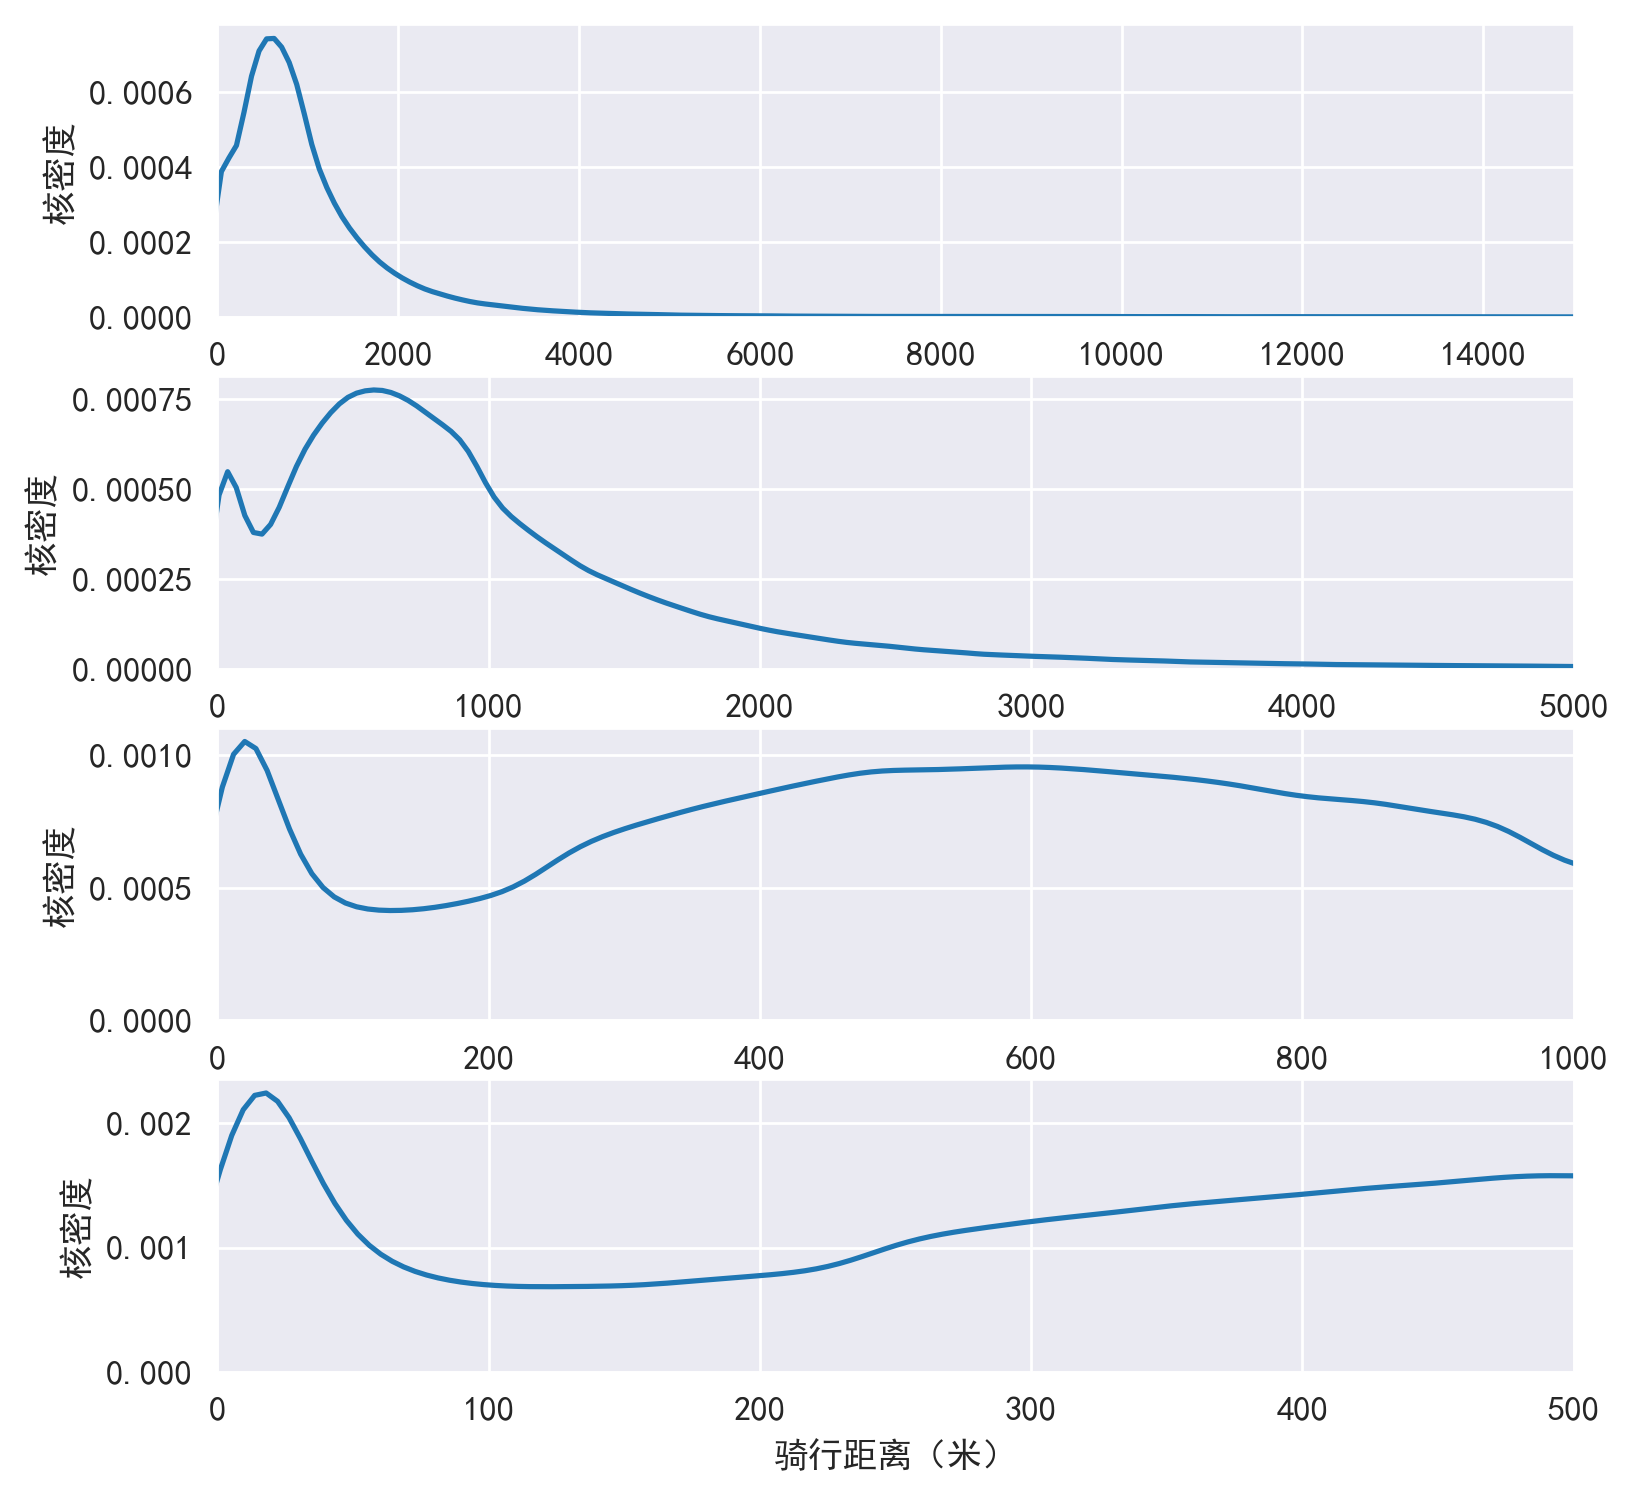

In [46]:
# 绘制距离分布的核密度分布（决定数据清洗阈值）
fig     = plt.figure(1,(7,7),dpi = 250)
ax1      = plt.subplot(411)
# 去除重复项
data_move_drop_duplicates = data_move.drop_duplicates(subset=['distance'])
sns.kdeplot(data_move_drop_duplicates[data_move_drop_duplicates['distance']<16000]['distance'])
plt.xlim(0,15000)
plt.ylabel('核密度')
ax2      = plt.subplot(412)
sns.kdeplot(data_move_drop_duplicates[data_move_drop_duplicates['distance']<6000]['distance'])
plt.xlim(0,5000)
plt.ylabel('核密度')
ax3      = plt.subplot(413)
sns.kdeplot(data_move_drop_duplicates[data_move_drop_duplicates['distance']<1500]['distance'])
plt.xlim(0,1000)
plt.ylabel('核密度')
ax4      = plt.subplot(414)
sns.kdeplot(data_move_drop_duplicates[data_move_drop_duplicates['distance']<750]['distance'])
plt.xlim(0,500)
plt.xlabel('骑行距离（米）')
plt.ylabel('核密度')
plt.show()

从核密度分布的情况来看，共享单车的骑行直线距离绝大部分在 `3km` 以内。同时也可以注意到骑行距离分布双峰形态，在 `100m` 内存在一个高峰，在 `200m ~ 1km` 则存在另一个高峰。

实际上 `100m` 内的高峰最大值仅在 `10m` 左右，这部分骑行实际上可能并没有完成用户的出行需求，更可能是用户扫码开锁后使用单车发现存在一定故障，再重新关锁。因此，这部分数据应予以剔除。另一方面，骑行距离过长的订单也应该予以剔除，其阈值可以定在 `10km` 以上。

我们需要剔除过长与过短的出行记录。

In [48]:
# 清洗骑行数据，删除过长与过短的出行
data_move_cleaned = data_move[(data_move['distance']>100)&(data_move['distance']<10000)]

### 3.2 骑行次数

统计每辆单车的单日骑行次数有助于帮助我们理解单车资源使用的整体情况。我们使用的是一天时间范围的数据，因此统计单日骑行次数只需要统计每辆单车的骑行订单量即可。

在统计时，用 `groupby` 函数对单车 `ID` 分组后进行计数。不过在这里，使用 `Series` 的 `value_counts` 方法也可以实现相同功能。

In [49]:
# 统计每辆车出现过几次，结果自动从大到小排序
data_move_cleaned['BIKE_ID'].value_counts()

713ED7A81FAD3233E0533C0BA8C09291    36
713F59A068220D6CE0533E0BA8C03AB5    36
7143F7BC1D8D0D68E0533E0BA8C06BBD    36
7169493318B60D74E0533E0BA8C01BB4    35
7169493314420D74E0533E0BA8C01BB4    35
                                    ..
713ED7940E3F3233E0533C0BA8C09291     1
713ED7A387A23233E0533C0BA8C09291     1
713ED7A387B23233E0533C0BA8C09291     1
713ED7A387B33233E0533C0BA8C09291     1
713ED79CE1753233E0533C0BA8C09291     1
Name: BIKE_ID, Length: 330367, dtype: int64

对上面结果再进行一次 `value_counts` ，即可统计出单车使用次数的分布情况。

In [50]:
# 车辆的使用次数统计
datatoplot = data_move_cleaned['BIKE_ID'].value_counts().value_counts()
datatoplot

1     129564
2      39853
3      28798
4      25083
5      20309
6      17224
7      13924
8      11337
9       9371
10      7556
11      6046
12      4808
13      3758
14      2979
15      2263
16      1849
17      1381
18      1118
19       806
20       659
21       459
22       346
23       243
24       212
25       120
26        97
27        70
28        50
29        32
30        20
31        14
32         7
33         4
36         3
34         2
35         2
Name: BIKE_ID, dtype: int64

对统计的数据进行柱状图绘制。从单日的骑行次数分布频数可以看到，多数共享单车每天仅被使用一次。

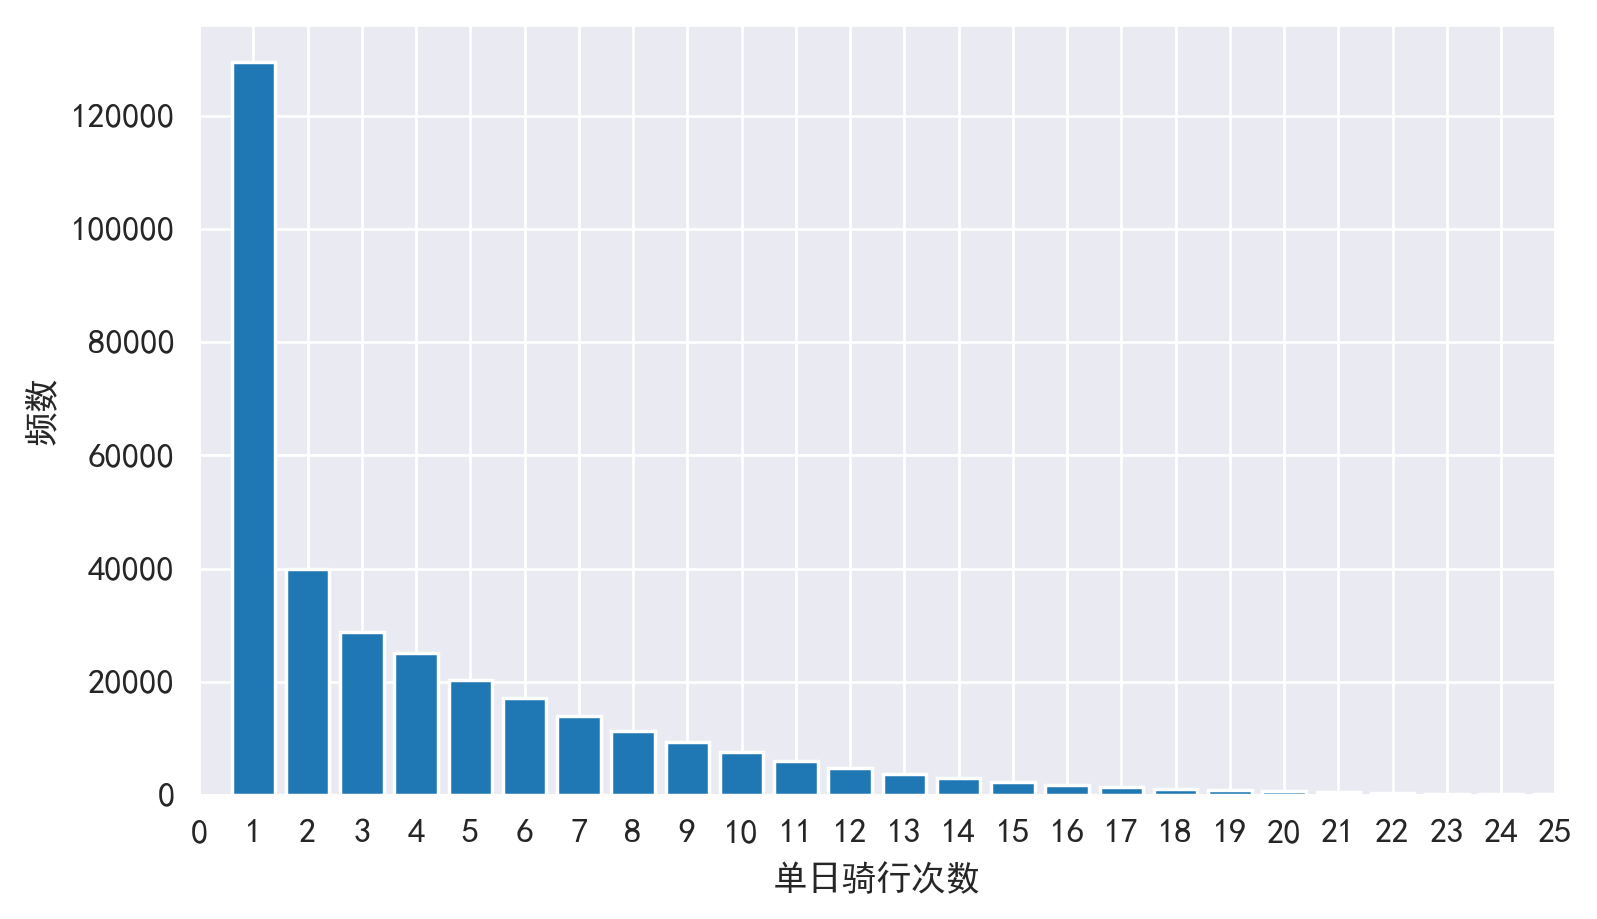

In [51]:
fig     = plt.figure(1,(7,4),dpi = 250)
ax1      = plt.subplot(111)
plt.bar(datatoplot.index,datatoplot)
plt.xticks(range(0,40,1),range(0,40,1))
plt.xlim(0,25)
plt.xlabel('单日骑行次数')
plt.ylabel('频数')
plt.show()